mounting the drive

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


importing libraries

In [2]:
# Import required libraries
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetB0
from glob import glob
from tqdm import tqdm

defineing dataset paths

In [3]:
# Define dataset paths on Google Drive
BASE_DIR = '/content/drive/MyDrive/CS6353/Project/Datasets'
SHENZHEN_IMAGE_DIR = os.path.join(BASE_DIR, "pulmonary-chest-xray-abnormalities", "ChinaSet_AllFiles(1)", "CXR_png")
SHENZHEN_MASK_DIR = os.path.join(BASE_DIR, "shcxr-lung-mask", "mask", "mask")


dataset path tests

In [4]:
import os

BASE_DIR = '/content/drive/MyDrive/CS6353/Project/Datasets'
SHENZHEN_IMAGE_DIR = os.path.join("/content/drive/MyDrive/CS6353/Project/Datasets/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/CXR_png")
SHENZHEN_MASK_DIR = os.path.join(BASE_DIR, "shcxr-lung-mask", "mask")

print("Sample X-ray files:")
print(os.listdir(SHENZHEN_IMAGE_DIR)[:5])

print("Sample mask files:")
print(os.listdir(SHENZHEN_MASK_DIR)[:5])


Sample X-ray files:
['CHNCXR_0001_0.png', 'CHNCXR_0002_0.png', 'CHNCXR_0003_0.png', 'CHNCXR_0004_0.png', 'CHNCXR_0006_0.png']
Sample mask files:
['CHNCXR_0004_0_mask.png', 'CHNCXR_0003_0_mask.png', 'CHNCXR_0005_0_mask.png', 'CHNCXR_0007_0_mask.png', 'CHNCXR_0001_0_mask.png']


/content/drive/MyDrive/CS6353/Project/Datasets/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles (1)/CXR_png

directories for output

In [5]:
# Directories for storing processed data
OUTPUT_DIR = '/content/drive/MyDrive/CS6353/Project/lung_segmentation'
TRAIN_IMAGE_DIR = os.path.join(OUTPUT_DIR, "train", "image")
TRAIN_MASK_DIR = os.path.join(OUTPUT_DIR, "train", "mask")
TEST_IMAGE_DIR = os.path.join(OUTPUT_DIR, "test", "image")
TEST_MASK_DIR = os.path.join(OUTPUT_DIR, "test", "mask")

In [6]:
# Create directories
os.makedirs(TRAIN_IMAGE_DIR, exist_ok=True)
os.makedirs(TRAIN_MASK_DIR, exist_ok=True)
os.makedirs(TEST_IMAGE_DIR, exist_ok=True)
os.makedirs(TEST_MASK_DIR, exist_ok=True)

In [7]:
# Load mask files and split into train/test
mask_files = sorted(glob(os.path.join(SHENZHEN_MASK_DIR, "*.png")))
train_files, test_files = train_test_split(mask_files, test_size=0.15, random_state=42)
# Process and store images and masks
for mask_file in tqdm(mask_files):
    base_file = os.path.basename(mask_file).replace("_mask", "")
    image_file = os.path.join(SHENZHEN_IMAGE_DIR, base_file)

    image = cv2.imread(image_file)
    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 256))
    mask = cv2.resize(mask, (256, 256))

    if mask_file in train_files:
        cv2.imwrite(os.path.join(TRAIN_IMAGE_DIR, base_file), image)
        cv2.imwrite(os.path.join(TRAIN_MASK_DIR, base_file), mask)
    else:
        cv2.imwrite(os.path.join(TEST_IMAGE_DIR, base_file), image)
        cv2.imwrite(os.path.join(TEST_MASK_DIR, base_file), mask)



100%|██████████| 566/566 [39:52<00:00,  4.23s/it]


visulaising the dataset

In [8]:
def visualize_samples(image_dir, mask_dir, num_samples=5):
    image_files = sorted(os.listdir(image_dir))[:num_samples]
    mask_files = sorted(os.listdir(mask_dir))[:num_samples]

    plt.figure(figsize=(15, 5))
    for i, (image_file, mask_file) in enumerate(zip(image_files, mask_files)):
        image = cv2.imread(os.path.join(image_dir, image_file))
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)

        plt.subplot(2, num_samples, i + 1)
        plt.title(f"Image {i + 1}")
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.title(f"Mask {i + 1}")
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

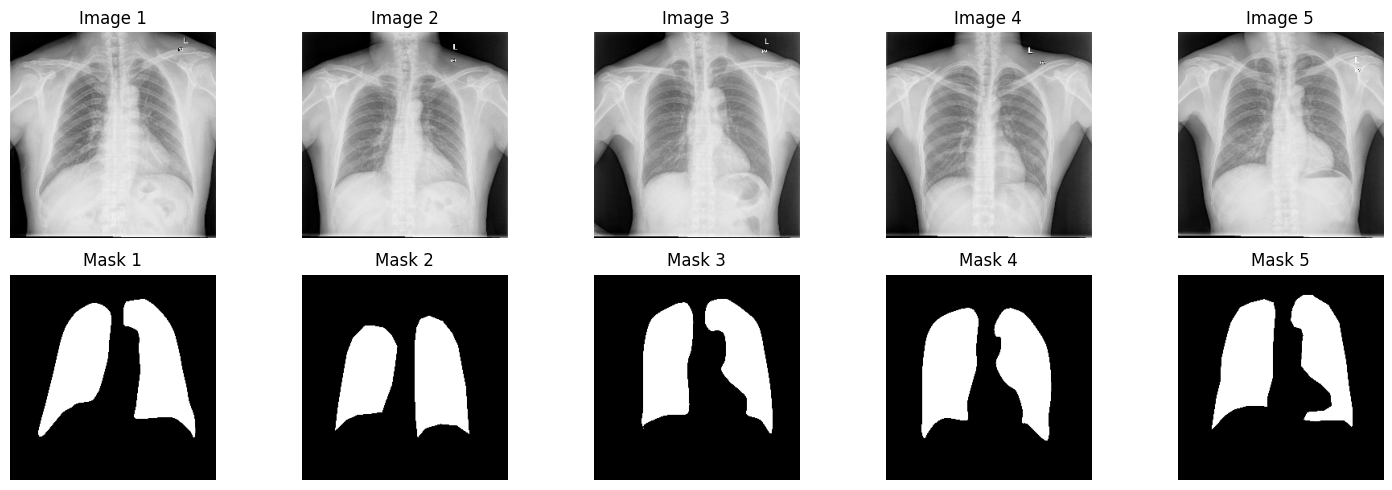

In [9]:
visualize_samples(TRAIN_IMAGE_DIR, TRAIN_MASK_DIR)

In [13]:
import os
import cv2

# Check all image and mask shapes
image_files = sorted(os.listdir(TRAIN_IMAGE_DIR))
mask_files = sorted(os.listdir(TRAIN_MASK_DIR))

for img_file, mask_file in zip(image_files, mask_files):
    img_path = os.path.join(TRAIN_IMAGE_DIR, img_file)
    mask_path = os.path.join(TRAIN_MASK_DIR, mask_file)

    image = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if image is None or mask is None:
        print(f"Failed to load: {img_path} or {mask_path}")
        continue

    if image.shape != (256, 256, 3):
        print(f"Inconsistent image shape: {img_path}, Shape: {image.shape}")
    if mask.shape != (256, 256):
        print(f"Inconsistent mask shape: {mask_path}, Shape: {mask.shape}")


data generator

In [14]:
def data_generator(image_dir, mask_dir, batch_size=16, augment=True):
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    while True:
        batch_images = []
        batch_masks = []

        for _ in range(batch_size):
            idx = np.random.randint(len(image_files))  # Random index

            # Load image and mask
            img_path = os.path.join(image_dir, image_files[idx])
            mask_path = os.path.join(mask_dir, mask_files[idx])

            image = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if image is None or mask is None:
                print(f"Failed to load: {img_path} or {mask_path}")
                continue

            # Resize and normalize
            try:
                image = cv2.resize(image, (256, 256)) / 255.0
                mask = cv2.resize(mask, (256, 256)) / 255.0
                mask = np.expand_dims(mask, axis=-1)
            except Exception as e:
                print(f"Error processing: {img_path} or {mask_path}, {e}")
                continue

            # Check shapes
            if image.shape != (256, 256, 3) or mask.shape != (256, 256, 1):
                print(f"Shape mismatch: Image {image.shape}, Mask {mask.shape}")
                continue

            batch_images.append(image)
            batch_masks.append(mask)

        if len(batch_images) == batch_size and len(batch_masks) == batch_size:
            yield np.array(batch_images), np.array(batch_masks)
        else:
            print("Incomplete batch, skipping.")




In [15]:
gen = data_generator(TRAIN_IMAGE_DIR, TRAIN_MASK_DIR, batch_size=16)

try:
    batch_images, batch_masks = next(gen)
    print(f"Batch Images Shape: {batch_images.shape}")
    print(f"Batch Masks Shape: {batch_masks.shape}")
except Exception as e:
    print(f"Error: {e}")



Batch Images Shape: (16, 256, 256, 3)
Batch Masks Shape: (16, 256, 256, 1)


In [ ]:
print(f"Image Shape: {image.shape}, Mask Shape: {mask.shape}")

Image Shape: (256, 256, 3), Mask Shape: (256, 256)


In [ ]:
if image is None:
    raise ValueError(f"Image failed to load: {image_files[idx]}")
if mask is None:
    raise ValueError(f"Mask failed to load: {mask_files[idx]}")

Unet model

In [16]:
def build_unet(input_shape=(256, 256, 3)):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)

    # Encoder
    encoder_output = base_model.output  # Shape: (None, 8, 8, 1280)

    # Bottleneck
    bottleneck = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(encoder_output)

    # Decoder
    # Block 1
    up1 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bottleneck)  # Upsample to (16, 16)
    concat1 = layers.concatenate([up1, base_model.get_layer('block6a_expand_activation').output])  # Match layer output
    dec1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(concat1)

    # Block 2
    up2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(dec1)  # Upsample to (32, 32)
    concat2 = layers.concatenate([up2, base_model.get_layer('block4a_expand_activation').output])  # Match layer output
    dec2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat2)

    # Block 3
    up3 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(dec2)  # Upsample to (64, 64)
    concat3 = layers.concatenate([up3, base_model.get_layer('block3a_expand_activation').output])  # Match layer output
    dec3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat3)

    # Block 4
    up4 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(dec3)  # Upsample to (128, 128)
    concat4 = layers.concatenate([up4, base_model.get_layer('block2a_expand_activation').output])  # Match layer output
    dec4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(concat4)

    # Final Block
    up5 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(dec4)  # Upsample to (256, 256)
    dec5 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(up5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(dec5)

    return models.Model(inputs=base_model.input, outputs=outputs)


In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    filepath="best_model.keras",  # Save model in .keras format
    save_best_only=True,  # Only save the model if the validation loss improves
    monitor="val_loss",  # Monitor validation loss
    verbose=1  # Print progress
)

# Define the early stopping callback
early_stopping = EarlyStopping(
    patience=5,  # Stop training if no improvement after 5 epochs
    restore_best_weights=True,  # Restore the best weights during training
    monitor="val_loss",  # Monitor validation loss
    verbose=1  # Print progress
)

training the model

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.7942 - loss: 0.4189
Epoch 1: val_loss improved from inf to 1.93441, saving model to best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 95s 492ms/step - accuracy: 0.7973 - loss: 0.4133 - val_accuracy: 0.7627 - val_loss: 1.9344
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9709 - loss: 0.0766
Epoch 2: val_loss did not improve from 1.93441
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.9709 - loss: 0.0764 - val_accuracy: 0.7591 - val_loss: 2.8693
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9777 - loss: 0.0560
Epoch 3: val_loss did not improve from 1.93441
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.9777 - loss: 0.0560 - val_accuracy: 0.7488 - val_loss: 3.2480
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.9784 - loss: 0.0537
Epoch 4: val_loss did not improve from 1.93441
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - accuracy: 0.9784 - loss: 0.0537 - val_a

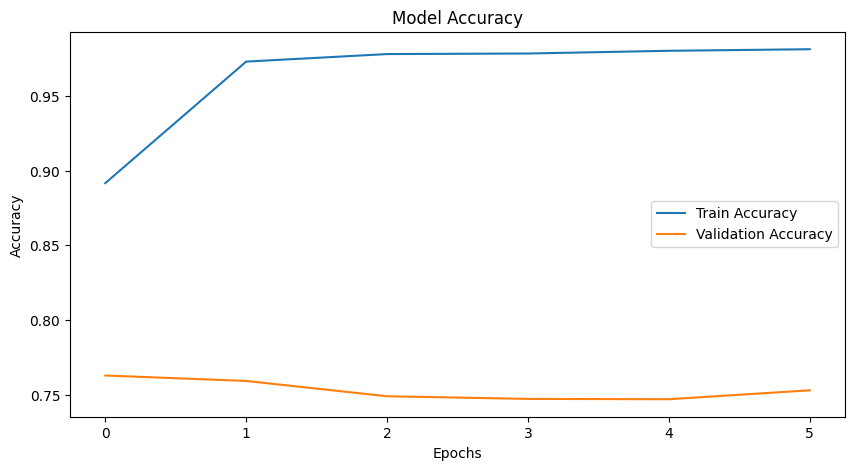

In [19]:
# Compile and train the model
model = build_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

train_gen = data_generator(TRAIN_IMAGE_DIR, TRAIN_MASK_DIR, batch_size=16)
val_gen = data_generator(TEST_IMAGE_DIR, TEST_MASK_DIR, batch_size=16, augment=False)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(os.listdir(TRAIN_IMAGE_DIR)) // 16,
    validation_steps=len(os.listdir(TEST_IMAGE_DIR)) // 16,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)



# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


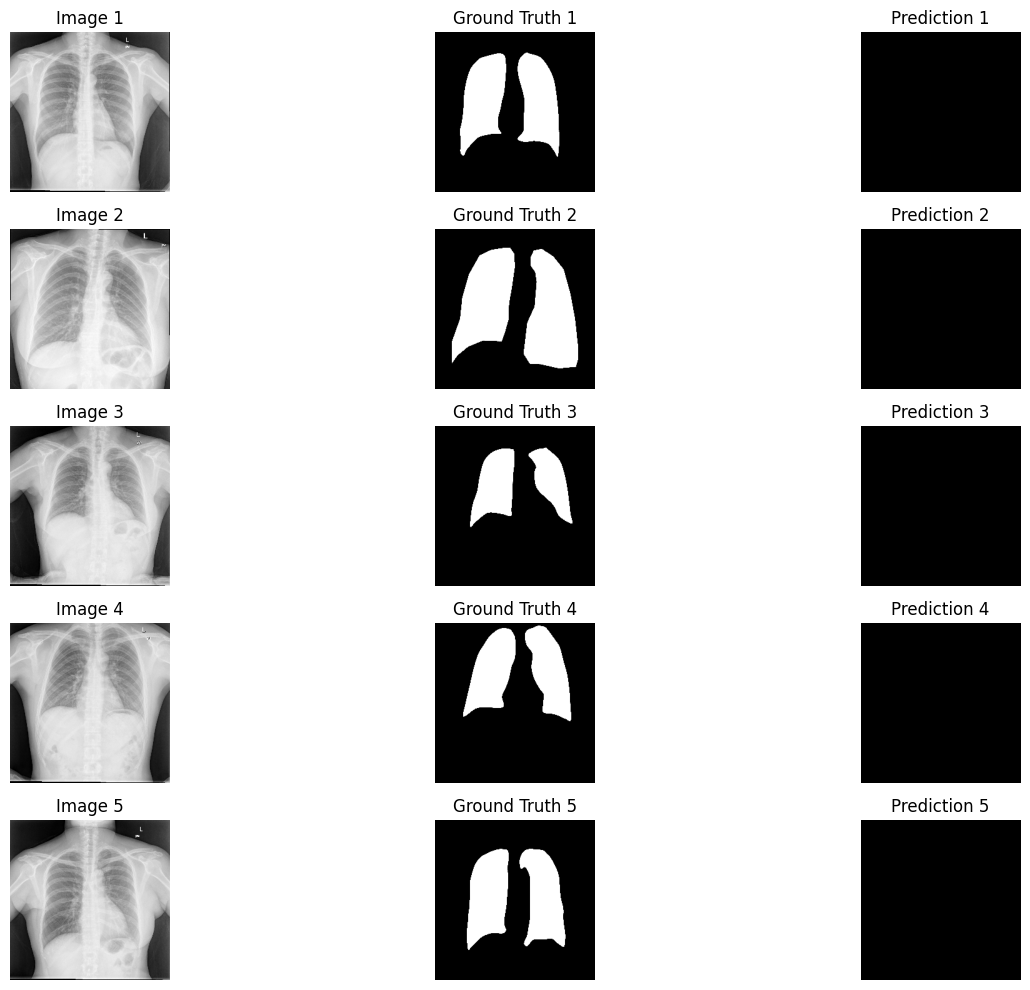

In [20]:
# Visualize predictions
def visualize_predictions(image_dir, mask_dir, model, num_samples=5):
    image_files = sorted(os.listdir(image_dir))[:num_samples]
    mask_files = sorted(os.listdir(mask_dir))[:num_samples]

    plt.figure(figsize=(15, 10))
    for i, (image_file, mask_file) in enumerate(zip(image_files, mask_files)):
        image = cv2.imread(os.path.join(image_dir, image_file))
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
        image_resized = image / 255.0
        pred_mask = model.predict(np.expand_dims(image_resized, axis=0))[0]
        pred_mask = (pred_mask > 0.5).astype(np.uint8).squeeze()

        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.title(f"Image {i + 1}")
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.title(f"Ground Truth {i + 1}")
        plt.imshow(mask, cmap='gray')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.title(f"Prediction {i + 1}")
        plt.imshow(pred_mask, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions(TEST_IMAGE_DIR, TEST_MASK_DIR, model)